# About

The purpose of this notebook is (misleadingly) not to recreate the binomial neuron paper, but rather to explore the gradient approximation methods and see if we can get a small working model.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import numpy as np

import copy

# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

# Table 2 - says batch_size should be 32
batch_size = 100

train_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = True, transform = transform)
test_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

features, labels = next(iter(train_loader))

# Gradient Approximation Functions

In [3]:
# Surrogate gradient implementation from https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb
class SurrogateGradientSpike(torch.autograd.Function):
    '''takes in [-inf, inf] values'''
    scale = 100.0
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateGradientSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# Sigmoid Bernoulli Spikes Generation
# Implementation from https://github.com/NECOTIS/Parallelizable-Leaky-Integrate-and-Fire-Neuron/blob/main/neurons/paralif.py
class StochasticStraightThrough(torch.autograd.Function):
    '''takes in [0, 1] values'''
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.bernoulli(input)
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input*input

# Implementation from https://github.com/NECOTIS/Parallelizable-Leaky-Integrate-and-Fire-Neuron/blob/main/neurons/paralif.py
class GumbelSoftmax(torch.nn.Module):
    def __init__(self, device, hard=True, tau=1.0):
        super().__init__()
        self.hard = hard
        self.tau = tau
        self.uniform = torch.distributions.Uniform(0, 1)
        self.softmax = torch.nn.Softmax(dim=0)
  
    def forward(self, logits):
        # Sample uniform noise
        unif = self.uniform.sample(logits.shape + (2,)).to(device)
        # Compute Gumbel noise from the uniform noise
        gumbels = -torch.log(-torch.log(unif))
        # Apply softmax function to the logits and Gumbel noise
        y_soft = self.softmax(torch.stack([(logits + gumbels[...,0]) / self.tau,
                                                     (-logits + gumbels[...,1]) / self.tau]))[0]
        if self.hard:
            # Use straight-through estimator
            y_hard = torch.where(y_soft > 0.5, 1.0, 0.0)
            ret = y_hard - y_soft.detach() + y_soft
        else:
            # Use reparameterization trick
            ret = y_soft
        return ret

In [4]:
# gs = GumbelSoftmax(device=device)
# x = torch.randn(3,5, device=device)
# gs(x)

# Gradient Approximations Experiments

In [5]:
x1 = torch.randn(3, 5)
x2 = x1.clone()
x3 = x1.clone()

x1.requires_grad_(True)
x2.requires_grad_(True)
x3.requires_grad_(True)
x1

tensor([[-1.3896,  1.4036,  0.2547,  1.8045, -1.6439],
        [ 0.3134,  1.8319,  0.4706, -1.9237,  0.6153],
        [ 0.4079,  0.7234,  0.6961, -1.4115,  1.5947]], requires_grad=True)

In [6]:
gs = GumbelSoftmax(device=device)
output1 = gs(x1)
output2 = SurrogateGradientSpike.apply(x2)
output3 = StochasticStraightThrough.apply(F.sigmoid(x3))

loss1 = output1.sum()
loss2 = output2.sum()
loss3 = output3.sum()
loss1.backward()
loss2.backward()
loss3.backward()

In [7]:
print(x1.grad)
print(x2.grad)
print(x3.grad)

tensor([[0.0749, 0.0029, 0.2931, 0.4982, 0.0574],
        [0.4983, 0.3068, 0.3083, 0.2936, 0.4883],
        [0.3650, 0.3157, 0.1573, 0.0034, 0.0177]])
tensor([[5.1049e-05, 5.0041e-05, 1.4277e-03, 3.0372e-05, 3.6559e-05],
        [9.5641e-04, 2.9476e-05, 4.3289e-04, 2.6743e-05, 2.5578e-04],
        [5.7270e-04, 1.8590e-04, 2.0056e-04, 4.9487e-05, 3.8835e-05]])
tensor([[0.0319, 0.1271, 0.1386, 0.1042, 0.0220],
        [0.1409, 0.1025, 0.1457, 0.0142, 0.1478],
        [0.1441, 0.1481, 0.1481, 0.0309, 0.1166]])


We do the exact same thing again, but with a substantially larger matrix.

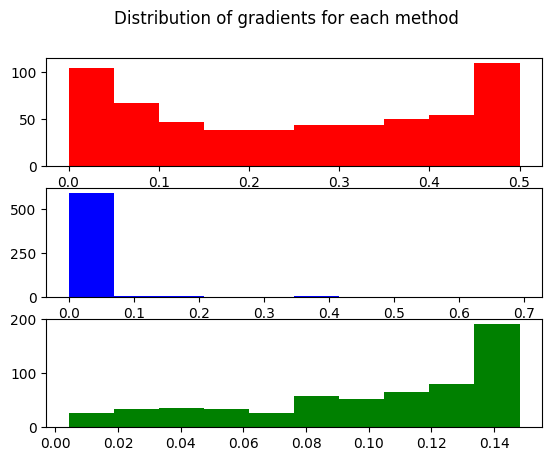

In [8]:
x1 = torch.randn(20, 30)
x2 = x1.clone()
x3 = x1.clone()

x1.requires_grad_(True)
x2.requires_grad_(True)
x3.requires_grad_(True)

gs = GumbelSoftmax(device=device)
output1 = gs(x1)
output2 = SurrogateGradientSpike.apply(x2)
output3 = StochasticStraightThrough.apply(F.sigmoid(x3))

loss1 = output1.sum()
loss2 = output2.sum()
loss3 = output3.sum()
loss1.backward()
loss2.backward()
loss3.backward()

fig, axs = plt.subplots(3, 1)

# plt.hist(x1.grad.detach().view(-1))
axs[0].hist(x1.grad.detach().view(-1), color = 'red')
axs[1].hist(x2.grad.detach().view(-1), color = 'blue')
axs[2].hist(x3.grad.detach().view(-1), color = 'green')

fig.suptitle('Distribution of gradients for each method')
plt.show()

# Neurons

In [9]:
class BinomialUnit(nn.Module):
    def __init__(self, in_features: int, out_features: int, spiker="gumbel", is_final_layer=False):
        super().__init__()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.bernoulli_generator = torch.bernoulli
        self.storage = torch.zeros(in_features, device=device)
        self.W = nn.Parameter(torch.empty((in_features, out_features))) # synaptic weights
        self.b = nn.Parameter(torch.empty(out_features))
        self.h = nn.Tanh()
        
        # gumbel and surrogate take in [-inf, inf]
        # ste takes in [0, 1]
        if spiker == "gumbel":
            self.generate = GumbelSoftmax(device=device)
        elif spiker == "ste":
            self.generate = StochasticStraightThrough.apply
        elif spiker == 'surrogate':
            self.generate = SurrogateGradientSpike.apply
        else:
            raise ValueError("spiker must be in ['gumbel', 'ste', 'surrogate']")
        
        self.generate_out = copy.deepcopy(self.generate)
        
        # he_normal for sigmoid or xavier for tahn
        if spiker == 'ste':
            nn.init.kaiming_normal_(self.W)
        else:
            nn.init.xavier_normal_(self.W)
        nn.init.constant_(self.b, 0.0)
        
        self.in_features = in_features
        self.out_features = out_features
        self.spiker = spiker
        self.is_final_layer = is_final_layer
        self.output_storage = torch.zeros((batch_size, out_features), device=device) if is_final_layer else None
    
    def forward(self, x, t, T=None):
        
        if self.spiker == 'ste':
            x = F.sigmoid(x)
        else:
            x = F.tanh(x)
        
        # makes x binary
        x = self.generate(x)
        
        # Accumulation
        x = x + self.storage
        self.storage = x.detach()

        # Unbiased estimator of the expectation
        x = x / (t + 1)  # Equation 3 on page 4
        
        # Membrane potential
        x = x @ self.W + self.b # Equation 4 on page 4
        
        # x here is NOT binary
        
        if self.spiker == 'ste':
            x = F.sigmoid(x)
        else:
            x = F.tanh(x)
        
        x = self.generate_out(x)
        if self.is_final_layer: #accumulate the outputs
            self.output_storage.add_(x)
            if t + 1 == T: # return the expectation at the end
                x = self.output_storage / T
                return x
        return x.detach()

    def reset_storage(self):
        self.storage = torch.zeros(self.in_features, device=device)
        if self.is_final_layer:
            self.output_storage = torch.zeros((batch_size, self.out_features), device=device)

In [10]:
# class EConv2d(nn.Module):
#     def __init__(
#         self, 
#         in_channels: int, 
#         out_channels: int, 
#         kernel_size: int,
#         stride: int = 1,
#         padding: int = 0
#     ):
        
#         super().__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         self.storage = None
#         self.sigmoid = nn.Sigmoid()
        
#         # Table 2 - Initialise the kernel with he_normal
#         nn.init.kaiming_normal_(self.conv.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.constant_(self.conv.bias, 0)
    
#     def forward(self, x, t = None):
#         x = self.conv(x)
        
#         # For conv_initial we only want a convolution, no spiking.
#         if t is None:
#             return x
        
#         if self.storage is None:
#             self.storage = torch.zeros_like(x, device=device)
        
#         # Squashes to [0, 1]
#         x = self.sigmoid(x)
#         x = torch.bernoulli(x).detach() - x.detach() + x # STE
        
#         # Accumulation
#         x = x + self.storage
#         self.storage = x.detach()
        
#         # Expectation
#         x = x / (t + 1)
        
#         return x
    
#     def reset_storage(self):
#         self.storage = None

In [30]:
class Network(nn.Module):
    def __init__(self, in_features: int, out_features: int, spiker = "gumbel"):
        super().__init__()
        self.BU1 = BinomialUnit(in_features, 10, spiker = spiker, is_final_layer=True)
        # self.BU2 = BinomialUnit(256, 128, spiker = spiker)
        # self.BU3 = BinomialUnit(128, out_features, spiker = spiker, is_final_layer=True)
        self.spiker = spiker
        
        # gumbel and surrogate take in [-inf, inf]
        # ste takes in [0, 1]
        if spiker == "gumbel":
            self.generate = GumbelSoftmax(device=device)
        elif spiker == "ste":
            self.generate = StochasticStraightThrough.apply
        elif spiker == 'surrogate':
            self.generate = SurrogateGradientSpike.apply
        else:
            raise ValueError("spiker must be in ['gumbel', 'ste', 'surrogate']")
    
    def forward(self, x_init, T):
        if self.spiker == 'ste':
            x_init = F.sigmoid(x_init)
        else:
            x_init = F.tanh(x_init)
        x_init = self.generate(x_init)
        
        # Accumulation
        for t in range(T):
            x = self.BU1(x_init, t, T)
            # x = self.BU2(x, t)
            # x = self.BU3(x, t, T)

        return x.softmax(dim = -1)
    
    def reset_storage(self):
        for m in self.modules():
            if isinstance(m, BinomialUnit):
                m.reset_storage()
    
model = Network(28*28, 10).to(device)
# See table 2 on page 9
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adamax(model.parameters(), lr = 0.1)
criterion = nn.CrossEntropyLoss()

In [31]:
n_epochs = 250
T = 3
losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features.view(batch_size, -1), T)
        loss = criterion(outputs, labels) # Algorithm on page 7 line 17

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.reset_storage()
        
        epoch_loss += loss.item()
        if (i+1) % 100 == 0:
            printf(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    losses += [epoch_loss / len(train_loader)]

Epoch [250/250], Step [600/600], Loss: 2.2876

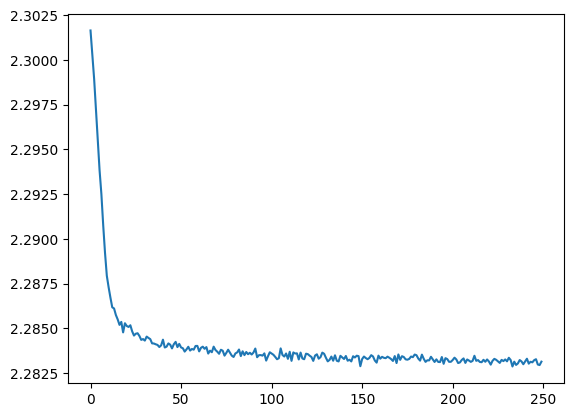

In [32]:
plt.plot(torch.arange(n_epochs), losses);

In [36]:
torch.save(model.state_dict(), 'models/binomial_neuron_recreation2.pt')

# Loading the RNN
model = Network(784, 10).to(device)
model.load_state_dict(torch.load('models/binomial_neuron_recreation2.pt')) # batch size 32

<All keys matched successfully>

# Inference

In [38]:
T = 3
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    n_correct = 0
    n_total = 0
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features.view(batch_size, -1), T)
        predictions = outputs.argmax(dim = -1)
        n_correct += (predictions == labels).sum().item()
        n_total += len(labels)
    print(f'Test Accuracy: {n_correct / n_total * 100}%')

Test Accuracy: 10.89%
